- eda_20250211 で作った drop_cols_d 以外の特徴量を使って学習する

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics 
from src.featuring import add_feature

# Config

In [3]:
class cfg:
    exp = "exp017"
    dataset_path = "../dataset/v5.0"
    feature_set = "all"
    valid_ratio = 0.2
    threshold_corr = 0.90
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [4]:
with open("./eda_20250211/feature_groups_drop_cols.json", "r") as f:
    drop_cols_d = json.load(f)
# print(drop_cols_d)
drop_cols = []
for k, v in drop_cols_d.items():
    drop_cols += v
print(len(drop_cols))

1348


In [5]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
feature_set = [col for col in feature_set if col not in drop_cols]
print(f"feature col length: {len(feature_set)}")



targets = feature_metadata["targets"]
targets = ["target", "target_agnes_20"]


feature col length: 1098


# Load Data

In [6]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 1101)


,era,feature_abrasive_forcipate_crewel,feature_accadian_pledged_bore,feature_acclamatory_draconian_view,feature_according_tied_bedlam,feature_acetose_permeated_irregular,feature_acheulian_constrainable_ahriman,feature_acknowledged_anteorbital_bilker,feature_acrylic_gallic_wine,feature_adaptative_nasal_monastery,...,feature_zincoid_supreme_brummell,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zoological_peristomial_scute,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,2,2,2,2,2,2,2,2,2,...,2,4,3,2,2,1,0,0,0.25,0.25
n003bba8a98662e4,0001,2,2,1,2,2,2,2,2,2,...,2,0,0,2,2,0,0,0,0.25,0.25


(3577827, 1101)


,era,feature_abrasive_forcipate_crewel,feature_accadian_pledged_bore,feature_acclamatory_draconian_view,feature_according_tied_bedlam,feature_acetose_permeated_irregular,feature_acheulian_constrainable_ahriman,feature_acknowledged_anteorbital_bilker,feature_acrylic_gallic_wine,feature_adaptative_nasal_monastery,...,feature_zincoid_supreme_brummell,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zoological_peristomial_scute,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,2,2,0,2,2,3,2,0,0,...,2,4,2,0,0,0,1,0,0.75,0.75
n001e1318d5072ac,0575,1,3,1,4,3,3,3,0,4,...,4,1,1,0,1,3,4,3,0.00,0.00


# Preprocess

In [7]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())


(2746270, 1101) (3577827, 1101)


,era,feature_abrasive_forcipate_crewel,feature_accadian_pledged_bore,feature_acclamatory_draconian_view,feature_according_tied_bedlam,feature_acetose_permeated_irregular,feature_acheulian_constrainable_ahriman,feature_acknowledged_anteorbital_bilker,feature_acrylic_gallic_wine,feature_adaptative_nasal_monastery,...,feature_zincoid_supreme_brummell,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zoological_peristomial_scute,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
nffce425c89dc5da,1153,4,1,4,2,0,4,0,4,1,...,2,2,4,0,0,3,3,4,NaN,NaN
nffd4e7b55827375,1153,2,1,4,2,2,2,1,4,3,...,4,0,2,1,3,0,4,0,NaN,NaN
nffea643830509bf,1153,3,2,4,4,4,3,2,2,3,...,0,4,4,2,2,4,3,0,NaN,NaN
nffea66c53d0aebe,1153,1,1,0,0,3,2,1,0,2,...,1,2,2,2,3,2,2,2,NaN,NaN
nfff2966f1f157af,1153,1,3,3,2,4,0,0,1,3,...,0,0,3,2,4,0,0,0,NaN,NaN


In [8]:
print(data.shape)

# data = add_feature(data)
print(data.shape)

(6324097, 1101)
(6324097, 1101)


In [9]:
# era 単位で分ける
all_era = data["era"].unique()
n_idx = int(len(all_era) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train_era = all_era[:n_idx]
cond_train = data["era"].isin(train_era)
train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)

del data; gc.collect()


(6324097, 1101)
922
(4817566, 1101) (1506531, 1101)


0

In [10]:
train["era_int"] = train["era"].astype(int)

# Training

In [11]:
features = feature_set + [col for col in train.columns if "per_era" in col]
print(len(features))

1098


In [12]:
train = train.reset_index(drop=True)

In [13]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)
    for i in range(4):
        cond_train = (train["era_int"] % 4 == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train[cond_train]
        tmp_valid = valid[cond_valid]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))
        del tmp_train, tmp_valid; gc.collect()

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5490
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 1098
[LightGBM] [Warning] Provided parameters 

8


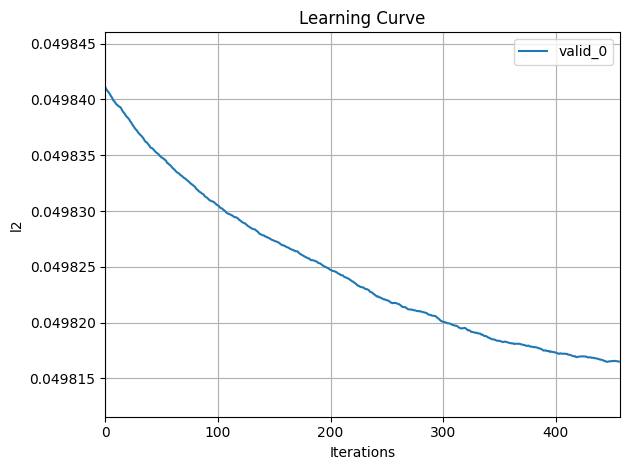

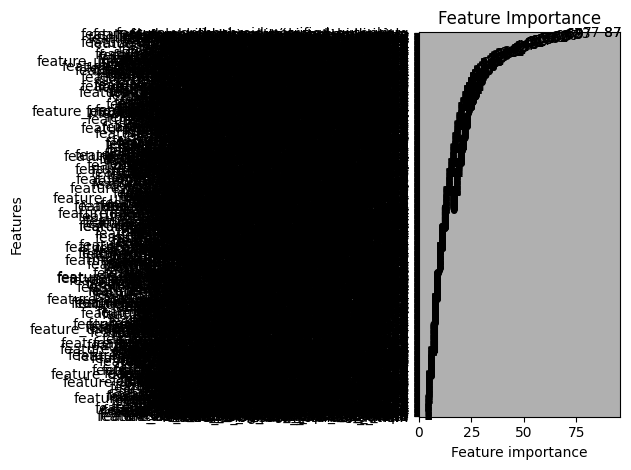

In [14]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

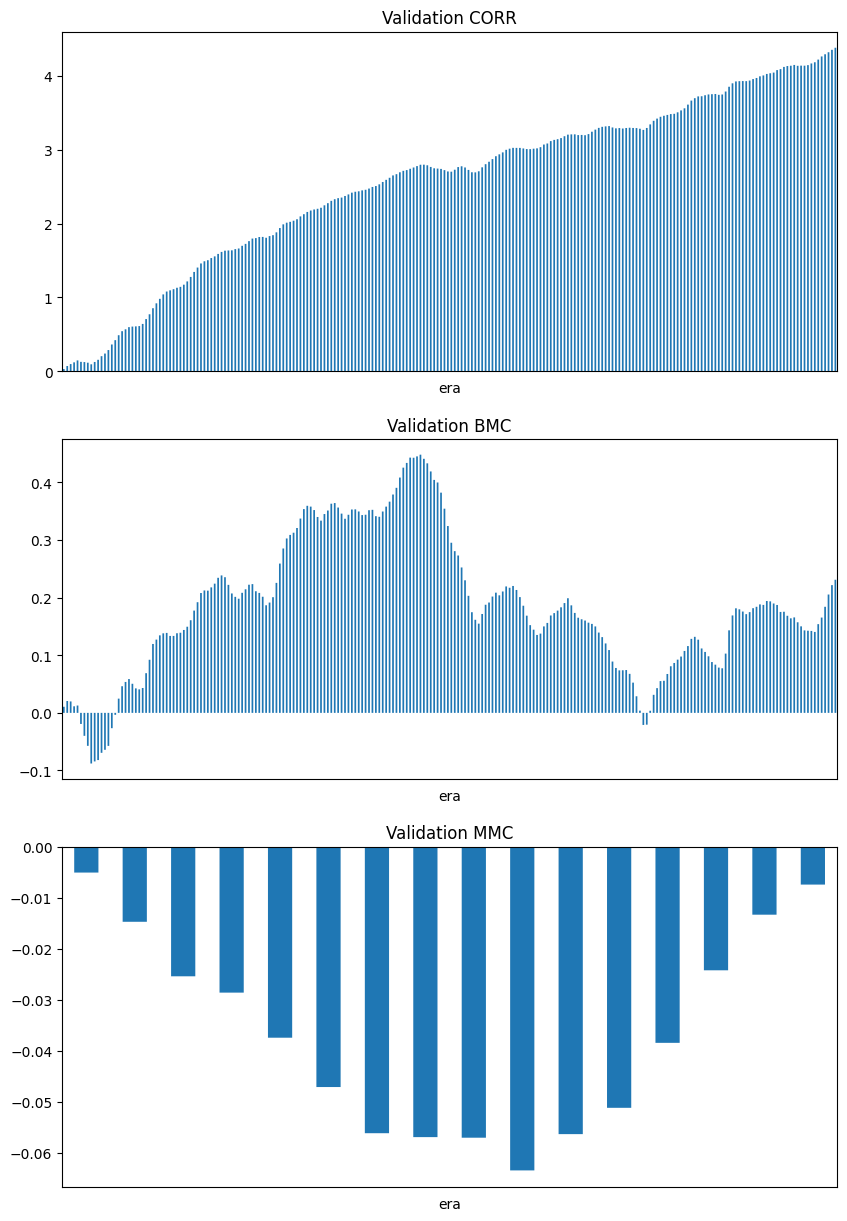

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0    0.01938  0.020549    0.943136           0.104084 -0.000463  0.008692   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0  -0.053222          0.058467  0.001023  0.012772   0.080068   
 
    bmc_max_drawdown  
 0          0.469207  ,
           pred
 era           
 0923  0.030044
 0924  0.041437
 0925  0.026359
 0926  0.023110
 0927  0.026253
 ...        ...
 1144  0.042637
 1145  0.029513
 1146  0.027432
 1147  0.032712
 1148  0.027931
 
 [226 rows x 1 columns],
           pred
 era           
 0923  0.010586
 0924  0.010004
 0925 -0.000758
 0926 -0.008433
 0927  0.001342
 ...        ...
 1144  0.011444
 1145  0.018695
 1146  0.021294
 1147  0.016320
 1148  0.009332
 
 [226 rows x 1 columns],
           pred
 era           
 1133 -0.005042
 1134 -0.009662
 1135 -0.010701
 1136 -0.003204
 1137 -0.008850
 1138 -0.009684
 1139 -0.009063
 1140 -0.000767
 1141 -0.000115
 1142 -0.006420

In [15]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
caluculate_metrics(cfg.dataset_path, valid)
